**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [2]:
import keras
import numpy as np
import scipy
import io
import base64
from IPython.display import HTML
import skvideo
#skvideo.setFFmpegPath("/anaconda3/lib/python3.6/skvideo")
import skvideo.io
import cv2
import json
from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,Reshape,BatchNormalization,Dropout,Flatten, Convolution2D
from keras.utils import np_utils

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 

\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:

\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [3]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [4]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

If we are training our agent we have two options: the first is to act randomly (the goal is to explore the map), the seconod is to follow the policy we have learned (the goal is to improve the policy). When we are testing we always follow the policy we have learned (it can be that even when we are testing we sometimes allow the agent to act randomly).
Epsilon is essential since it allows us to explore the map and train the agent at the same time.

***
### The Game

In [5]:
#The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

#```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
#```

TypeError: 'NoneType' object is not iterable

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [6]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board<0,2] = 256
        b[self.x,self.y,:]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, train=True):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over, reward

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [7]:
# parameters
size = 13
T=50
temperature=0.3
epochs_train=10 # set small when debugging
epochs_test=10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

Board is a matrix whose elements can be 0, +0.5, -1 representing rispectively the presence of nothing, cheese and poisoned cheese.
Position is a matrix that contains a one in the current position of the rat.
Note that both matrices have a 2margin to simplify the code.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [8]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, 4, size=1)[0]

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [9]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0
    
        while not game_over:
            # The agent performs an action
            action = agent.learned_act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            state, reward, game_over, reward_1 = env.act(action, False)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

        ##### FILL IN HERE
        
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [14]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 3.5/5.0. Average score (-1.5)
Win/lose count 4.5/6.0. Average score (-1.5)
Win/lose count 2.5/4.0. Average score (-1.5)
Win/lose count 3.5/4.0. Average score (-1.25)
Win/lose count 1.0/6.0. Average score (-2.0)
Win/lose count 5.5/5.0. Average score (-1.5833333333333333)
Win/lose count 5.0/6.0. Average score (-1.5)
Win/lose count 2.5/5.0. Average score (-1.625)
Win/lose count 5.5/8.0. Average score (-1.7222222222222223)
Win/lose count 1.0/5.0. Average score (-1.95)
Final score: -1.95


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}

Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




__Answer 5.1__

\begin{equation*}
Q^{\pi}(s,a) = E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] = \sum_{s',a'}{E_{p^{\pi}}[r(s,a) + \gamma\sum_{1 \leq t\leq T}\gamma^{t-1}r(s_{t},a_{t})|s_{0}=s,a_{0}=a, s_{1}=s', a_{1}=a']P(s_{1}=s'|s_{0}=s,a_{0}=a)}\pi(a'|s') = E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

__Answer 5.2__

\begin{equation*}
Q^{\pi}(s,a) = \sum_{s',a'}{[r(s,a) + \gamma Q^{\pi}(s',a')]P(s_{1}=s'|s_{0}=s,a_{0}=a)}\pi(a'|s') = \sum_{s'}P(s_{1}=s'|s_{0}=s,a_{0}=a){[r(s,a) + \gamma \sum_{a'}\pi(a'|s') Q^{\pi}(s',a')]} \leq \sum_{s'}P(s_{1}=s'|s_{0}=s,a_{0}=a){[r(s,a) + \gamma \max_{a'} Q^{\pi}(s',a')]} = E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{\pi}(s',a')] 
\end{equation*}

and if the policy is optimal we have the equality since we can't improve the optimal policy.

__Answer 5.3__
We are looking for the optimal policy, i.e. a policy for which it holds:

\begin{equation*}
E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a') - Q^{*}(s,a)] = 0
\end{equation*}

So, the choiche of the loss 

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}

is reasonable since our neural network will predict the reward for each possible action.

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [10]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if(len(self.memory) < self.max_memory):
            self.memory.append(m)
            self.max_memory += 1
        else:
            self.memory[np.random.randint(len(self.memory))] = m

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]

***
The pipeline we will use for training is given below:

In [11]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            
            action = agent.act(state)
                        
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over, reward_1 = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [12]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        pass

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size,5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            
            episode = self.memory.random_access()
                        
            if episode[4]:
                ######## FILL IN
                input_states[i] = episode[0]
                target_q[i,:] = self.model.predict(episode[0].reshape((1,5,5,self.n_state)))
                target_q[i,int(episode[2])] = episode[3]
            else:
                ######## FILL IN
                input_states[i] = episode[0]
                target_q[i,:] = self.model.predict(episode[0].reshape((1,5,5,self.n_state)))
                target_q[i,int(episode[2])] = episode[3] + self.discount*int(np.amax(self.model.predict(episode[1].reshape((1,5,5,self.n_state))))) 
                        
        # instead of clipping we use tanh as activation function of the last layer
        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        ####### FILL IN
        
        model = keras.Sequential()
        model.add(Dense(250,activation='relu',input_shape=(5,5,self.n_state)))
        model.add(Dense(1000,activation='relu'))
        model.add(Dense(25,activation='relu'))
        model.add(Flatten())
        model.add(Dense(4,activation='tanh'))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()
    
    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape((1,5,5,self.n_state))))

In [120]:
T = 50
epochs_train = 50
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.4, memory_size=2000, batch_size = 32, n_state=2)
train(agent, env, epochs_train, prefix='fc_train10')
HTML(display_videos('fc_train100.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 5, 5, 250)         750       
_________________________________________________________________
dense_95 (Dense)             (None, 5, 5, 1000)        251000    
_________________________________________________________________
dense_96 (Dense)             (None, 5, 5, 25)          25025     
_________________________________________________________________
flatten_34 (Flatten)         (None, 625)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 4)                 2504      
Total params: 279,279
Trainable params: 279,279
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [13]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        
        nb_actions = 4
        model = Sequential()
        model.add(Convolution2D(32, (2, 2), input_shape=(5,5,self.n_state))) 
        model.add(Convolution2D(64, (2, 2))) 
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(nb_actions))
        model.add(Activation('tanh')) 
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()
        
    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape((1,5,5,self.n_state))))

In [24]:
T = 50
epochs_train = 50

env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.4, memory_size=2000, batch_size = 32, n_state=2)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train0.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              590848    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 4100      
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total para

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [31]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              590848    
_________________________________________________________________
activation_7 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 4100      
_________________________________________________________________
activation_8 (Activation)    (None, 4)                 0         
Total para

In [32]:
HTML(display_videos('cnn_test0.mp4'))

In [33]:
HTML(display_videos('fc_test0.mp4'))

__Answer__ 

First we fixed the temperature at 0.4. During training: with the first network the agent does not explore very well the map and often turns around the initial position, with the convolutional network the agent explores better the map but still has the tendency to rivist many times some cells. During testing in both cases the agent starts oscillating since the beginning.

Then we increased the temperature at 0.8. During training, in both cases the agent better explores the map since it can follow a path made by only red cases. During testing, in both cases the agent explores just few cases before starting oscillating.

Finally, we fixed the temperature at 0.2. During training we observe the agent's behaviour is very similar to the case with temperature=0.4. During testing: with the first network the agent starts oscillating since the very beginning, with the convolutional network the agent explores just few cases before starting oscillating.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [86]:
def train_explore(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    eps = 1
    decay_coeff = 0.99 
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        
        eps = eps*decay_coeff 
        agent.set_epsilon(eps) 
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)
            
            #agent.set_epsilon(agent.epsilon*decay_coeff)
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over, reward_1 = env.act(action)

            # Update the counters
            if reward_1 > 0:
                win = round(win + reward_1,2)
                
            if reward_1 < 0:
                lose = round(lose - reward_1,2)

            # Apply the reinforcement strategy
            loss = round(agent.reinforce(prev_state, state, action, reward, game_over), 2)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += round(win-lose,2)
        

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board<0,2] = 256
        b[self.x,self.y,:]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, train=True): #train
        """This function returns the new state, reward and decides if the
        game ends."""
        
        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1
        
        reward = 0
        
        reward_1 = 0

        no_out = 6
        
        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x
                reward -= no_out
                reward_1 -= no_out
                print("out")
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x
                reward -= no_out
                reward_1 -= no_out
                print("out")
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y 
                reward -= no_out
                reward_1 -= no_out
                print("out")
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y
                reward -= no_out
                reward_1 -= no_out
                print("out")
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        
        if train: 
            reward += -self.malus_position[self.x, self.y]             # = 
        self.malus_position[self.x, self.y] += 0.5 
        # 0.5 is the value that optimizes the average score. 
        
        reward += self.board[self.x, self.y]
        
        reward_1 += self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                        self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
          
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over, reward_1

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0

        self.board = bonus + malus
        
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
        
        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                        self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [87]:
# Training
T = 50
epochs_train = 100 
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 1, memory_size=2000, batch_size = 32, n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore0.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 4, 4, 32)          416       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_17 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1024)              590848    
_________________________________________________________________
activation_49 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 4100      
_________________________________________________________________
activation_50 (Activation)   (None, 4)                 0         
Total para

In [88]:
# Evaluation
epochs_test = 50
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore0.mp4'))

Win/lose count 15.0/1.0. Average score (14.0)
Win/lose count 14.5/0. Average score (14.25)
Win/lose count 9.5/1.0. Average score (12.333333333333334)
Win/lose count 12.0/0. Average score (12.25)
Win/lose count 10.5/0. Average score (11.9)
Win/lose count 8.0/0. Average score (11.25)
Win/lose count 12.0/0. Average score (11.357142857142858)
Win/lose count 12.5/0. Average score (11.5)
Win/lose count 11.0/0. Average score (11.444444444444445)
Win/lose count 11.5/0. Average score (11.45)
Win/lose count 8.5/0. Average score (11.181818181818182)
Win/lose count 10.0/1.0. Average score (11.0)
Win/lose count 11.0/1.0. Average score (10.923076923076923)
Win/lose count 8.0/0. Average score (10.714285714285714)
Win/lose count 9.5/0. Average score (10.633333333333333)
Win/lose count 8.0/0. Average score (10.46875)
Win/lose count 11.5/0. Average score (10.529411764705882)
Win/lose count 10.0/0. Average score (10.5)
Win/lose count 8.5/1.0. Average score (10.342105263157896)
Win/lose count 9.0/0. Avera

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D,Activation, AveragePooling2D,Flatten
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [15]:
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        #grid_size = grid_size+4
        self.grid_size = grid_size+4
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        #self.board = np.zeros((grid_size,grid_size))
        #self.position = np.zeros((grid_size,grid_size))
        #self.malus_position = np.zeros((grid_size,grid_size))
        
        self.board_humain = np.zeros((self.grid_size,self.grid_size))
        self.board_vampire = np.zeros((self.grid_size,self.grid_size))
        self.board_warevolves = np.zeros((self.grid_size,self.grid_size))
        self.board = {"human": self.board_humain, "vampire": self.board_vampire, "warevolves": self.board_warevolves}
        
        # changement
        self.board_vampire_malus = np.zeros((self.grid_size,self.grid_size))
        self.board_warevolves_malus = np.zeros((self.grid_size,self.grid_size))
        self.malus = {"vampire": self.board_vampire_malus, "warevolves": self.board_warevolves_malus}
        
        # coordinate of the vampires
        self.vampire_x = 0
        self.vampire_y = 0
        
        # coordinate of the warevolves
        self.warevolves_x = 1
        self.warevolves_y = 1
        
        self.coordinates ={"vampire": np.array((self.vampire_x, self.vampire_y)), "warevolves": np.array((self.warevolves_x, self.warevolves_y))}

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw) ######################################################
        print()

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board["human"]>0,:] = 256
        b[self.coordinates["warevolves"][0], self.coordinates["warevolves"][1], 2] = 256
        b[self.coordinates["vampire"][0], self.coordinates["vampire"][1], 0]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, species, train=True): #train
        """This function returns the new state, reward and decides if the
        game ends."""
        
        self.get_frame(int(self.t))
        
        if(species == "vampire"):
            other_species = "warevolves"
        else:
            other_species = "vampire"
        
        count_species = self.board[species][self.coordinates[species][0], self.coordinates[species][1]]
        
        self.board[species][self.coordinates[species][0], self.coordinates[species][1]] = 0
        
        reward = 0
        
        game_over = False
        
        not_go_out_of_map = 6
        
        self.t = self.t + 1
            
        p_win = 1
        
        # right
        if action == 0:
            if self.coordinates[species][0] == self.grid_size-3:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            else:
                self.coordinates[species][0] = self.coordinates[species][0] + 1
        # left
        elif action == 1:
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            else:
                self.coordinates[species][0] = self.coordinates[species][0]-1
        # north
        elif action == 2:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            else:
                self.coordinates[species][1] = self.coordinates[species][1] - 1
        #south
        elif action == 3:
            if self.coordinates[species][1] == self.grid_size - 3:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            else:
                self.coordinates[species][1] = self.coordinates[species][1] + 1

        # North Est (droite)
        elif action == 4:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if self.coordinates[species][0] == self.grid_size-3:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if(not(self.coordinates[species][1] == 2) and not(self.coordinates[species][0] == self.grid_size-3)):
                self.coordinates[species][0] = self.coordinates[species][0] + 1
                self.coordinates[species][1] = self.coordinates[species][1] - 1

        # North ouest 
        elif action == 5:
            if self.coordinates[species][1] == 2:
                self.coordinates[species][1] = self.coordinates[species][1]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0]
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if(not(self.coordinates[species][1] == 2) and not(self.coordinates[species][0] == 2)):
                self.coordinates[species][0] = self.coordinates[species][0] - 1
                self.coordinates[species][1] = self.coordinates[species][1] - 1

        # Sud ouest 
        elif action == 6:
            if self.coordinates[species][1] == self.grid_size-3:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if self.coordinates[species][0] == 2:
                self.coordinates[species][0] = self.coordinates[species][0] 
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if(not(self.coordinates[species][1] == self.grid_size-3) and not(self.coordinates[species][0] == 2)):
                self.coordinates[species][0] = self.coordinates[species][0] - 1
                self.coordinates[species][1] = self.coordinates[species][1] + 1

        # Sud est        
        elif action == 7:
            if self.coordinates[species][1] == self.grid_size-3:
                self.coordinates[species][1] = self.coordinates[species][1] 
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if self.coordinates[species][0] == self.grid_size - 3:
                self.coordinates[species][0] = self.coordinates[species][0] 
                reward -= not_go_out_of_map
                #game_over = True
                print("out " + str(action))
            if (not(self.coordinates[species][1] == self.grid_size-3) and not(self.coordinates[species][0] == self.grid_size - 3)):
                self.coordinates[species][0] = self.coordinates[species][0] + 1
                self.coordinates[species][1] = self.coordinates[species][1] + 1
        else:
            RuntimeError('Error: action not recognized')
        
        species_coor_1, species_coor_2 = self.coordinates[species][0],self.coordinates[species][1]
            
        self.board[species][species_coor_1, species_coor_2] = count_species
        
        count_other_species = self.board[other_species][species_coor_1, species_coor_2]
        
        if(self.board["human"][species_coor_1,species_coor_2] > 0):
            n_species = self.board[species][species_coor_1,species_coor_2]
            n_human = self.board["human"][species_coor_1,species_coor_2]
            
            if(n_species > n_human):
                self.board[species][species_coor_1,species_coor_2] += self.board["human"][species_coor_1,species_coor_2]
                self.board["human"][species_coor_1,species_coor_2] = 0
            else:
                p_win = n_species/(n_human*2)
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[species][species_coor_1,species_coor_2] += np.random.binomial(n_human, p_win)
                    self.board["human"][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board["human"][species_coor_1,species_coor_2] = np.random.binomial(n_human, 1-p_win)
                    
        
        elif(self.board[other_species][species_coor_1,species_coor_2] > 100):  ###############################################
            n_species = self.board[species][species_coor_1,species_coor_2]
            n_other_species = self.board[other_species][species_coor_1,species_coor_2]
            
            if(n_species >= 1.5*n_other_species):
                self.board[other_species][species_coor_1,species_coor_2] = 0 
            
            elif(1.5*n_species <= n_other_species):  
                self.board[species][species_coor_1,species_coor_2] = 0 
            
            elif(n_species <= n_other_species and n_species > n_other_species/1.5):
                p_win = n_species/(n_other_species*2)
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[other_species][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board[other_species][species_coor_1,species_coor_2] = np.random.binomial(n_other_species, 1-p_win)
                
            elif(n_species > n_other_species and n_species < 1.5*n_other_species):
                p_win = n_species/n_other_species - 0.5
                threshold = np.random.uniform(0, 1)
                
                # win
                if(p_win >= threshold):
                    self.board[species][species_coor_1,species_coor_2] = np.random.binomial(n_species, p_win)
                    self.board[other_species][species_coor_1,species_coor_2] = 0
                
                # loose
                else:
                    self.board[species][species_coor_1,species_coor_2] = 0
                    self.board[other_species][species_coor_1,species_coor_2] = np.random.binomial(n_other_species, 1-p_win)
            
            # chagement
            reward = reward - (self.board[other_species][species_coor_1,species_coor_2] - count_other_species)*p_win
            
            if(self.board[other_species][species_coor_1,species_coor_2] == 0):
                reward += 100*p_win
                game_over = True
                                
        #print("End: " + species + ": " + str(self.board[species][species_coor_1,species_coor_2]))
        
        reward = reward + (self.board[species][species_coor_1,species_coor_2] - count_species)*p_win
        
        reward_1 = np.copy(reward)
        
        if(train):    
            reward = reward - self.malus[species][species_coor_1, species_coor_2] 
        
        self.malus[species][species_coor_1, species_coor_2] += 1
        
        #print(self.board[species][species_coor_1,species_coor_2] - count_species)
        #print(p_win)
        
        #if(self.board[species][species_coor_1,species_coor_2] == 0):
        #    reward -= 100*(1 - p_win)
        
        # changement
        game_over = game_over or self.t > self.max_time #or self.board[species][species_coor_1,species_coor_2] == 0 
            
        state = np.concatenate((self.malus[species].reshape(self.grid_size, self.grid_size,1),
                                self.board["human"].reshape(self.grid_size, self.grid_size,1),
                                self.board["vampire"].reshape(self.grid_size, self.grid_size,1), #species
                                self.board["warevolves"].reshape(self.grid_size, self.grid_size,1)),axis=2) #other species
        
        return state, reward, game_over, reward_1

    def reset(self):
        """This function resets the game and returns the initial state"""

            
        self.vampire_x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.vampire_y = np.random.randint(3, self.grid_size-3, size=1)[0]
        
        self.warevolves_x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.warevolves_y = np.random.randint(3, self.grid_size-3, size=1)[0]
        
        self.coordinates ={"vampire": np.array((self.vampire_x, self.vampire_y)), "warevolves": np.array((self.warevolves_x, self.warevolves_y))}

        self.board_human = 1*np.random.binomial(1,self.temperature,size=self.grid_size**2) #(1+np.random.poisson(1,size=self.grid_size**2))
        self.board_human = self.board_human.reshape(self.grid_size,self.grid_size)
        
        self.board_human[self.vampire_x, self.vampire_y] = 0
        self.board_human[self.warevolves_x, self.warevolves_y] = 0    
        
        self.board_human[0:2, :] = 0
        self.board_human[:, 0:2] = 0
        self.board_human[-2:, :] = 0
        self.board_human[:, -2:] = 0
                
        #print(self.board_human)
        
        init_vampire =  10 #+ np.random.poisson(4)
        init_warevolves = 5 #+ np.random.poisson(4)
        
        #print(self.board_human)
        #print("vampire: " + str(init_vampire))
        #print("warevolves: " + str(init_warevolves))
            
        self.board_vampire = np.zeros((self.grid_size,self.grid_size))
        self.board_vampire[self.vampire_x, self.vampire_y] = init_vampire
            
        self.board_warevolves = np.zeros((self.grid_size,self.grid_size))
        self.board_warevolves[self.warevolves_x, self.warevolves_y] = init_warevolves
        
        self.board = {"human": self.board_human, "vampire": self.board_vampire, "warevolves":self.board_warevolves}

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))
        
        self.t = 0
        
        # changement
        self.board_vampire_malus = np.zeros((self.grid_size, self.grid_size))
        self.board_warevolves_malus = np.zeros((self.grid_size, self.grid_size))
        self.malus = {"vampire": self.board_vampire_malus, "warevolves": self.board_warevolves_malus}

        state = np.concatenate((self.malus["vampire"].reshape(self.grid_size, self.grid_size,1),
                                self.board["human"].reshape(self.grid_size, self.grid_size,1),
                                self.board["vampire"].reshape(self.grid_size, self.grid_size,1), #species
                                self.board["warevolves"].reshape(self.grid_size, self.grid_size,1)),axis=2) #other species
         
        return state

In [16]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory)>=self.max_memory:
            self.memory[np.random.randint(self.max_memory)]= m
        else:
            self.memory.append(m)

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]


class AI_train(object):
    
    def __init__(self, grid_size=5, lr=0.1, memory_size=100000, batch_size = 16, n_state=4):

        # Q learning parameters
        self.discount = 0.99
        self.nb_actions = 8
        self.memory = Memory(memory_size)
        self.batch_size = batch_size
        self.grid_size = grid_size+4
        self.history = []
        self.n_state = n_state
        self.loss = []

        # Net declaration
        model = Sequential()
        model.add(Convolution2D(16, (2, 2), input_shape=(self.grid_size,self.grid_size,self.n_state))) 
        model.add(Convolution2D(32, (2, 2))) 
        #model.add(Convolution2D(128,(3, 3)))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dense(self.nb_actions))
        model.add(Activation('tanh')) 
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()

        
    def act(self, state, epsilon):
        
        if np.random.rand() <= epsilon:
            action = np.random.randint(8)
        else:
            action = self.model.predict(state[np.newaxis,:,:,:])
            action = np.argmax(action)
            
        return action
    
    ################
    def setmap((height, width), start_position, map_commands_raw):
        self.map = Map((height, width), start_position, map_commands_raw, 10)
        self.coor = [start_position[0],start_position[1], self.map[start_position[0],start_position[1],self.creature]]
    
    def act_test(self, UPD):
        
        self.map.update(UPD)
        state = self.map.grid[self.coor[0]-10:self.coor[0]+10,self.coor[1]-10:self.coor[1]+10,3]
        action = self.model.predict(state[np.newaxis,:,:,:])
        action = np.argmax(action) 
        
        if action==1:
            move = [unit[0]-1,unit[1]-1]
        elif action==2:
            move = [unit[0]-1,unit[1]]
        elif action==3:
            move = [unit[0]-1,unit[1]+1]
        elif action==4:
            move = [unit[0],unit[1]-1]
        elif action==5:
            move = [unit[0],unit[1]+1]
        elif action==6:
            move = [unit[0]+1,unit[1]-1]
        elif action==7:
            move = [unit[0]+1,unit[1]]
        elif action==8:
            move = [unit[0]+1,unit[1]+1] 
        
        return move
    
    ###############
    
    def move(unit, nb_target, target):
        return ([unit[0], unit[1], nb_target , target])
    
    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        #Q-Learning with experience replay implementation

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size,self.grid_size,self.grid_size,self.n_state))
        target_q = np.zeros((self.batch_size, 8))
        
        for i in range(self.batch_size):
            
            batch = self.memory.random_access() #randomly selecting episodes
            
            if batch[4]: #game_over
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,self.grid_size,self.grid_size,self.n_state)))
                target_q[i,int(batch[2])] = batch[3]
            else:
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,self.grid_size,self.grid_size,self.n_state)))
                target_q[i,int(batch[2])] = batch[3] + self.discount*np.max(self.model.predict(batch[1].reshape((1,self.grid_size,self.grid_size,self.n_state))))
        
        target_q = np.clip(target_q, -1, 1)
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        #NB this is made useless by the squashing operation
        loss = self.model.train_on_batch(input_states, target_q)
        self.loss.append(loss)

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

In [17]:
def Connect_and_play(env, train=True):
     
    def decode_and_play(agent,state,species,epsilon):

            action = agent.act(state,epsilon)
            prev_state = state
            state, reward, Finished, reward_1 = env.act(action, species)

            # Update the counters
            if reward_1 > 0:
                win[species] = win[species] + reward_1
            if reward_1 < 0:
                lose[species] = lose[species] - reward_1

            # Apply the reinforcement strategy
            agent.reinforce(prev_state, state,  action, reward, Finished)
            return state, Finished        

    Finished = False

####### TRAINING LOCALLY ########

    if train==True:
        
        nb_of_players =2
        env.reset()
        species = 'vampire'
        observations = []
        replaybuffer1 = []
        replaybuffer2 = []
        prefix = "ciao"
        score = dict(zip(['vampire','warevolves'],[0,0]))
        epoch=131
        epsilon = 1
        agent1= AI_train()
        #agent2= AI_train()
        win = dict(zip(['vampire','warevolves'],[0,0]))
        lose = dict(zip(['vampire','warevolves'],[0,0]))
        
        for e in range(epoch):
            # At each epoch, we restart to a fresh game and get the initial state
            state = env.reset()
            # This assumes that the games will terminate
            Finished = False
            
            if(epsilon > 0.3):
                epsilon = epsilon*0.99
            
            if(e == 100):
                epsilon = 0
            
            while not Finished:
                if species == 'vampire': 
                    state, Finished = decode_and_play(agent1,state,species,epsilon)
                    #species = 'warevolves'
                #else:
                    #state, Finished = decode_and_play(agent2,state,species,epsilon)
                    #species = 'vampire'

            if e % 4 == 0:
                env.draw(prefix+str(e))
                print(e)
                
            for specie in ['vampire','warevolves']:
                score[specie] = round(win[specie]-lose[specie],2)
            
            print("Epoch {:03d}/{:03d} | win {:.4f} lose {:.4f} | score warevolves {:.4f}"
                  .format(e, epoch, win['vampire'], lose['vampire'],score['warevolves']))
            
            win = dict(zip(['vampire','warevolves'],[0,0]))
            lose = dict(zip(['vampire','warevolves'],[0,0]))
            
            plt.plot(agent1.loss)
            #plt.plot(agent2.loss)

            #score += win-lose

            #print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
            #  .format(e, epoch, loss, win, lose, win-lose))
            agent1.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
                
###################### COMPETITION CODE ###########################

    elif train == False:
        
        HOST = "localhost"
        PORT = "5555"
        path='tobedefined'
        
        runprog = subprocess.Popen(r"C:\Users\Utilisateur\Documents\AI\VampiresVSWerewolvesGameServer.exe")
        #Connection to the server
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((HOST, int(PORT)))
        sock.send("NME".encode("ascii"))
        sock.send(struct.pack("1B", 1))
        sock.send("1".encode("ascii"))
           
        def decode_and_play(self, sock):
            
            data = bytes()
            while len(data) < 3:
                time.sleep(0.02)
                data += sock.recv(3 - len(data))
                #Decoding package   
            header = data.decode("ascii")

            if header == "END":
                print("END")
                # ending the party and starting a new one
            elif header == "BYE":
                sock.close()
                time.sleep(1)
                runprog.kill()
                Finished = True
            # SET
            elif header == "SET":
                (height, width)= receive_data(sock, 2, "2B")

            #HUM
            elif header == "HUM":
                number_of_homes = receive_data(sock, 1, "1B")[0]
                homes_raw = receive_data(sock, number_of_homes * 2, "{}B".format(number_of_homes * 2))

            #HME
            elif header == "HME":
                start_position = tuple(receive_data(sock, 2, "2B"))
                #start_position=start_position[::-1]

            elif header == "MAP":
                number_map_commands = receive_data(sock,1, "1B")[0]
                map_commands_raw = receive_data(sock, number_map_commands * 5, "{}B".format(number_map_commands * 5))
                agent1.setmap((height, width), start_position, map_commands_raw)

            elif header == "UPD":
                number_upd_commands = receive_data(sock,1, "1B")[0]
                upd_commands_raw = receive_data(sock, number_upd_commands * 5, "{}B".format(number_upd_commands * 5))
                MOV = agent1.act_test(upd_commands_raw)
                sock.send("MOV".encode("ascii"))
                sock.send(struct.pack("1B", len(MOV)))
                for i in MOV:
                    try:
                        sock.send(struct.pack("5B",i[0],i[1],i[2],i[3],i[4]))
                    except sock.error as e:
                        pass
            else: 
                print('Protocol Error')  
                
            while not Finished: 
                self.decode_and_play(sock)

    return agent1#, agent2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 8, 8, 16)          272       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          2080      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1606656   
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               131200    
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
__________

out 4
out 6
Epoch 081/131 | win 2.0000 lose 12.0000 | score warevolves 0.0000
out 7
out 4
out 2
out 5
out 5
Epoch 082/131 | win 7.0000 lose 30.0000 | score warevolves 0.0000
out 2
Epoch 083/131 | win 2.0000 lose 6.0000 | score warevolves 0.0000
out 2
out 2
out 7
out 0

84
Epoch 084/131 | win 1.0000 lose 24.0000 | score warevolves 0.0000
out 6
out 5
out 5
out 5
Epoch 085/131 | win 2.0000 lose 24.0000 | score warevolves 0.0000
out 4
out 5
Epoch 086/131 | win 2.0000 lose 12.0000 | score warevolves 0.0000
Epoch 087/131 | win 2.0000 lose 0.0000 | score warevolves 0.0000
out 6
out 5

88
Epoch 088/131 | win 1.0000 lose 12.0000 | score warevolves 0.0000
out 5
out 4
out 7
Epoch 089/131 | win 3.0000 lose 18.0000 | score warevolves 0.0000
Epoch 090/131 | win 5.0000 lose 0.0000 | score warevolves 0.0000
Epoch 091/131 | win 5.0000 lose 0.0000 | score warevolves 0.0000
out 5

92
Epoch 092/131 | win 2.0000 lose 6.0000 | score warevolves 0.0000
out 6
Epoch 093/131 | win 3.0000 lose 6.0000 | score ware

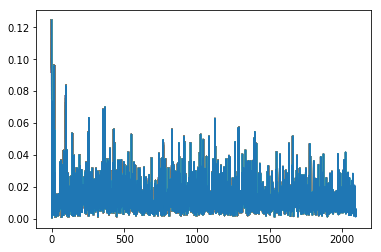

In [21]:
env = EnvironmentExploring(grid_size=13, max_time=50, temperature=0.3)
Connect_and_play(env) 

# paramètres 

# temperature = 0.2

# epoch=50

# epsilon = 1
# 0.99

# init_vampire =  10 
# init_warevolves = 10
# self.board_human = 3

# self.malus[species][species_coor_1, species_coor_2] += 4